# Student-T Regression

# Imports

In [1]:
from xgboostlss.model import *
from xgboostlss.distributions.StudentT import *
from xgboostlss.datasets.data_loader import load_simulated_studentT_data

import multiprocessing
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
train, test = load_simulated_studentT_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Distribution Selection

In [3]:
# Specifies Student-T distribution with exp response function and option to stabilize Gradient/Hessian.
xgblss = XGBoostLSS(
    StudentT(stabilization="None",        # Options are "None", "MAD", "L2".
             response_fn="softplus",      # Function to transform the df and scale parameters, e.g., "exp" or "softplus".
             loss_fn="nll"                # Loss function. Options are "nll" (negative log-likelihood) or "crps"(continuous ranked probability score).
            )
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

    # Float/Int sample_type
        # {"param_name": ["sample_type", low, high, log]}
            # sample_type: str, Type of sampling, e.g., "float" or "int"
            # low: int, Lower endpoint of the range of suggested values
            # high: int, Upper endpoint of the range of suggested values
            # log: bool, Flag to sample the value from the log domain or not
        # Example: {"eta": "float", low=1e-5, high=1, log=True]}

    # Categorical sample_type
        # {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
            # sample_type: str, Type of sampling, either "categorical"
            # choice1, choice2, choice3, ...: str, Possible choices for the parameter
        # Example: {"booster": ["categorical", ["gbtree", "dart"]]}

    # For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
        # {"param_name": ["none", [value]]},
            # param_name: str, Name of the parameter
            # value: int, Value of the parameter
        # Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=5,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                            )

[I 2023-06-28 14:37:24,783] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-dyy_Sbbh\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/05:00

[I 2023-06-28 14:37:30,609] Trial 0 finished with value: 3196.4295412 and parameters: {'eta': 0.085284545993243, 'max_depth': 5, 'gamma': 0.008281813217718322, 'subsample': 0.3192052915467602, 'colsample_bytree': 0.8117966196670028, 'min_child_weight': 6.040820194945254e-05, 'booster': 'gbtree'}. Best is trial 0 with value: 3196.4295412.
[I 2023-06-28 14:37:42,948] Trial 1 finished with value: 3373.1796874 and parameters: {'eta': 0.00018194160825789674, 'max_depth': 5, 'gamma': 0.005450542070817752, 'subsample': 0.3062025746916945, 'colsample_bytree': 0.6584528599616577, 'min_child_weight': 0.00020820871605440756, 'booster': 'gbtree'}. Best is trial 0 with value: 3196.4295412.
[I 2023-06-28 14:37:46,468] Trial 2 finished with value: 3207.5408202000003 and parameters: {'eta': 0.5173121537049227, 'max_depth': 8, 'gamma': 1.0355940931243609e-05, 'subsample': 0.550687502594895, 'colsample_bytree': 0.3275834209781544, 'min_child_weight': 0.000613472722366893, 'booster': 'gbtree'}. Best is t

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [40]:
# Set seed for reproducibility
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples = 1000
quant_sel = [0.05, 0.95] # Quantiles to calculate from predicted distribution

# Sample from predicted distribution
pred_samples = xgblss.predict(dtest,
                              pred_type="samples",
                              n_samples=n_samples,
                              seed=123)

# Calculate quantiles from predicted distribution
pred_quantiles = xgblss.predict(dtest,
                                pred_type="quantiles",
                                n_samples=n_samples,
                                quantiles=quant_sel)

# Returns predicted distributional parameters
pred_params = xgblss.predict(dtest,
                             pred_type="parameters")

In [7]:
pred_samples.head()

,y_sample0,y_sample1,y_sample2,y_sample3,y_sample4,y_sample5,y_sample6,y_sample7,y_sample8,y_sample9,...,y_sample990,y_sample991,y_sample992,y_sample993,y_sample994,y_sample995,y_sample996,y_sample997,y_sample998,y_sample999
0,1.837288,4.573308,1.526109,1.778393,2.180580,1.041643,-3.257300,-0.350994,3.243340,3.035835,...,-2.024325,1.285993,-0.828068,-1.878585,1.098881,1.331549,1.024853,3.201124,0.324078,-0.409758
1,0.905077,-1.083023,-1.250302,1.409431,1.035533,4.733918,5.203582,0.734847,3.863032,0.765036,...,3.187358,1.740085,-3.781074,-1.847415,-2.951063,0.391301,2.231301,-2.188371,5.682708,1.565759
2,1.668794,2.392630,2.224844,2.682910,2.223904,4.751781,3.178637,1.068526,2.359271,2.321751,...,3.466668,5.196637,1.678499,2.287818,1.357987,0.748859,4.404084,3.078838,0.341472,3.932621
3,-0.187779,0.462003,3.792182,0.874968,0.300728,3.061445,2.162031,-1.257608,0.957365,0.006120,...,6.296700,2.269555,2.772566,-3.169004,0.773150,1.423193,3.424505,-0.585881,-2.052784,0.380606
4,3.355009,-1.119407,1.042638,2.030699,-0.230337,0.486885,3.299291,-0.503933,2.387546,0.689108,...,0.870914,6.550049,6.590244,6.187500,3.661657,2.957248,-0.068758,1.879938,-0.652950,0.859701


In [8]:
pred_quantiles.head()

,quant_0.05,quant_0.95
0,-1.905289,4.023575
1,-2.213171,4.884935
2,-0.579279,4.857813
3,-2.144487,4.645252
4,-0.451898,6.079043


In [9]:
pred_params.head()

,df,loc,scale
0,10.817161,1.082811,1.509647
1,10.817161,1.268106,2.036557
2,10.817161,2.059402,1.465533
3,10.817161,1.158573,1.875000
4,10.817161,2.806506,1.901647


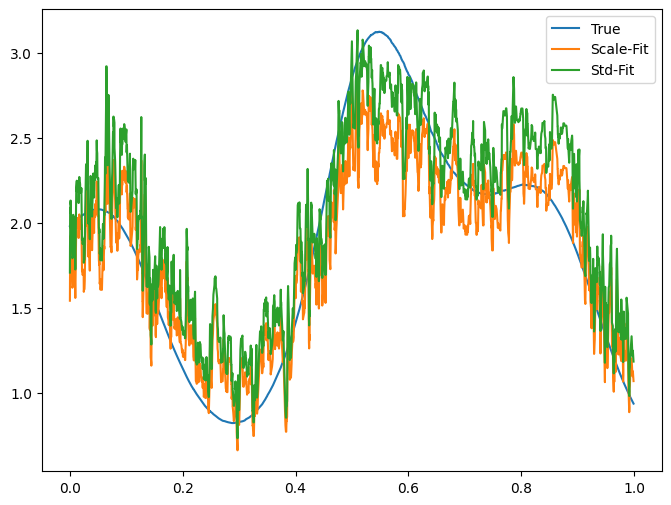

In [41]:
# Note that the variance for the Student-T distribution is defined as df/(df-2) * scale**2. Hence, we need to transform the predicted scale parameter to arrive at the variance.
pred_params["var"] = (pred_params["df"]/(pred_params["df"]-2)) * pred_params["scale"]**2
pred_params["std"] = np.sqrt(pred_params["var"].values)
pred_params["x"] = test.x.values
pred_params["true"] = test.scale.values
pred_params.sort_values("x", ascending=True, inplace=True)

plt.figure(figsize=(8,6))
plt.plot("x", "true", data=pred_params, label="True")
plt.plot("x", "scale", data=pred_params, label="Scale-Fit")
plt.plot("x", "std", data=pred_params, label="Std-Fit")
plt.legend(loc=1)
plt.show()

# SHAP Interpretability

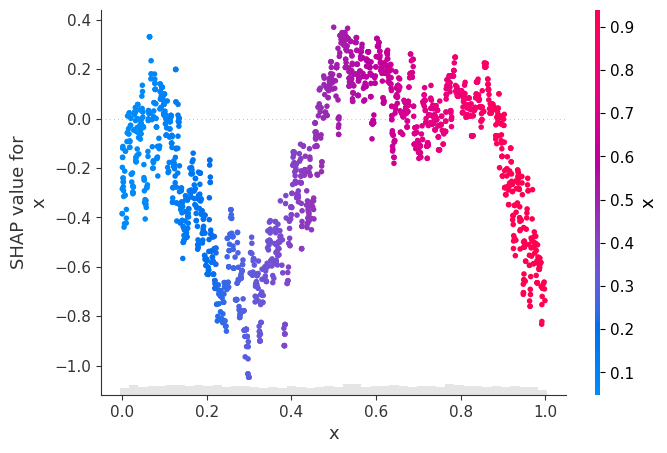

In [11]:
# Partial Dependence Plot of how x acts on scale parameter
xgblss.plot(X_test,
            parameter="scale",
            feature="x",
            plot_type="Partial_Dependence")

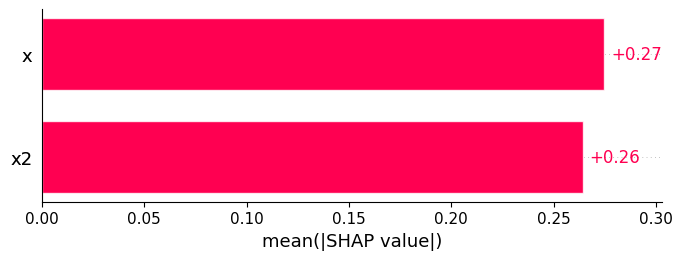

In [12]:
# Feature Importance of scale parameter
xgblss.plot(X_test,
            parameter="scale",
            plot_type="Feature_Importance")